# Big Data Final Project
The aim of this project is to analyze the chat messages that flow into a popular Battlefield 4 server. The dataset is quite large (84MB) at the time of collection.

I'm going to do a simple wordcount, as well as some specific cleanups that are required to get this data useable, such as removing messages that are server-generated, and some messages that have less than desireable words.

The complete dataset will not be available long after publishing for privacy reasons.

The environment I'm using is the Databricks Community Edition. 

**I have done my best to scrub swears out of the cesspool that Battlefield 4 chats are, but no guarantees. There are many different variations on words, and I can't catch them all.**

In [0]:
import urllib.request

urllib.request.urlretrieve("https://mtburnes.dev/tbl_chatlog.csv", "/tmp/chatlog.csv")
dbutils.fs.mv("file:/tmp/chatlog.csv", "dbfs:/data/chatlog.csv")

Out[54]: True

Test that we got the file, and that it's intact.

Then throw it in a data variable

In [0]:
rawRDD = sc.textFile("dbfs:/data/chatlog.csv")

Now remove those pesky quotes `"` from the beginning and end of every line

In [0]:
wordsRDD = rawRDD.flatMap(lambda line : line.strip("\"").split(" "))

Removing more junk:

Here we remove a bunch of uninteresting words like ``"the"``, `"and"`, a blank message `""`, and some pronouns.

Then we create a key-value pair of words.

In [0]:
import re
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover()
stopwords = remover.getStopWords()
stopwords.append('')

# This next cell has some naughty words in it.
## Not just swears, but also slurs.
## You have been warned.

If you're curious about how much people swear and say nasty things, you can comment out the `stopwords = stopwords + badwords` line.

Thanks to https://github.com/MauriceButler/badwords for the list.

In [0]:
badwords = ["4r5e", "5h1t", "5hit", "a55", "anal", "anus", "ar5e", "arrse", "arse", "ass", "ass-fucker", "asses", "assfucker", "assfukka", "asshole", "assholes", "asswhole", "a_s_s", "b!tch", "b00bs", "b17ch", "b1tch", "ballbag", "balls", "ballsack", "bastard", "beastial", "beastiality", "bellend", "bestial", "bestiality", "bi+ch", "biatch", "bitch", "bitcher", "bitchers", "bitches", "bitchin", "bitching", "bloody", "blow job", "blowjob", "blowjobs", "boiolas", "bollock", "bollok", "boner", "boob", "boobs", "booobs", "boooobs", "booooobs", "booooooobs", "breasts", "buceta", "bugger", "bum", "bunny fucker", "butt", "butthole", "buttmuch", "buttplug", "c0ck", "c0cksucker", "carpet muncher", "cawk", "chink", "cipa", "cl1t", "clit", "clitoris", "clits", "cnut", "cock", "cock-sucker", "cockface", "cockhead", "cockmunch", "cockmuncher", "cocks", "cocksuck", "cocksucked", "cocksucker", "cocksucking", "cocksucks", "cocksuka", "cocksukka", "cok", "cokmuncher", "coksucka", "coon", "cox", "crap", "cum", "cummer", "cumming", "cums", "cumshot", "cunilingus", "cunillingus", "cunnilingus", "cunt", "cuntlick", "cuntlicker", "cuntlicking", "cunts", "cyalis", "cyberfuc", "cyberfuck", "cyberfucked", "cyberfucker", "cyberfuckers", "cyberfucking", "d1ck", "damn", "dick", "dickhead", "dildo", "dildos", "dink", "dinks", "dirsa", "dlck", "dog-fucker", "doggin", "dogging", "donkeyribber", "doosh", "duche", "dyke", "ejaculate", "ejaculated", "ejaculates", "ejaculating", "ejaculatings", "ejaculation", "ejakulate", "f u c k", "f u c k e r", "f4nny", "fag", "fagging", "faggitt", "faggot", "faggs", "fagot", "fagots", "fags", "fanny", "fannyflaps", "fannyfucker", "fanyy", "fatass", "fcuk", "fcuker", "fcuking", "feck", "fecker", "felching", "fellate", "fellatio", "fingerfuck", "fingerfucked", "fingerfucker", "fingerfuckers", "fingerfucking", "fingerfucks", "fistfuck", "fistfucked", "fistfucker", "fistfuckers", "fistfucking", "fistfuckings", "fistfucks", "flange", "fook", "fooker", "fuck", "fucka", "fucked", "fucker", "fuckers", "fuckhead", "fuckheads", "fuckin", "fucking", "fuckings", "fuckingshitmotherfucker", "fuckme", "fucks", "fuckwhit", "fuckwit", "fudge packer", "fudgepacker", "fuk", "fuker", "fukker", "fukkin", "fuks", "fukwhit", "fukwit", "fux", "fux0r", "f_u_c_k", "gangbang", "gangbanged", "gangbangs", "gaylord", "gaysex", "goatse", "God", "god-dam", "god-damned", "goddamn", "goddamned", "hardcoresex", "hell", "heshe", "hoar", "hoare", "hoer", "homo", "hore", "horniest", "horny", "hotsex", "jack-off", "jackoff", "jap", "jerk-off", "jism", "jiz", "jizm", "jizz", "kawk", "knob", "knobead", "knobed", "knobend", "knobhead", "knobjocky", "knobjokey", "kock", "kondum", "kondums", "kum", "kummer", "kumming", "kums", "kunilingus", "l3i+ch", "l3itch", "labia", "lust", "lusting", "m0f0", "m0fo", "m45terbate", "ma5terb8", "ma5terbate", "masochist", "master-bate", "masterb8", "masterbat*", "masterbat3", "masterbate", "masterbation", "masterbations", "masturbate", "mo-fo", "mof0", "mofo", "mothafuck", "mothafucka", "mothafuckas", "mothafuckaz", "mothafucked", "mothafucker", "mothafuckers", "mothafuckin", "mothafucking", "mothafuckings", "mothafucks", "mother fucker", "motherfuck", "motherfucked", "motherfucker", "motherfuckers", "motherfuckin", "motherfucking", "motherfuckings", "motherfuckka", "motherfucks", "muff", "mutha", "muthafecker", "muthafuckker", "muther", "mutherfucker", "n1gga", "n1gger", "nazi", "nigg3r", "nigg4h", "nigga", "niggah", "niggas", "niggaz", "nigger", "niggers", "nob", "nob jokey", "nobhead", "nobjocky", "nobjokey", "numbnuts", "nutsack", "orgasim", "orgasims", "orgasm", "orgasms", "p0rn", "pawn", "pecker", "penis", "penisfucker", "phonesex", "phuck", "phuk", "phuked", "phuking", "phukked", "phukking", "phuks", "phuq", "pigfucker", "pimpis", "piss", "pissed", "pisser", "pissers", "pisses", "pissflaps", "pissin", "pissing", "pissoff", "poop", "porn", "porno", "pornography", "pornos", "prick", "pricks", "pron", "pube", "pusse", "pussi", "pussies", "pussy", "pussys", "rectum", "retard", "rimjaw", "rimming", "s hit", "s.o.b.", "sadist", "schlong", "screwing", "scroat", "scrote", "scrotum", "semen", "sex", "sh!+", "sh!t", "sh1t", "shag", "shagger", "shaggin", "shagging", "shemale", "shi+", "shit", "shitdick", "shite", "shited", "shitey", "shitfuck", "shitfull", "shithead", "shiting", "shitings", "shits", "shitted", "shitter", "shitters", "shitting", "shittings", "shitty", "skank", "slut", "sluts", "smegma", "smut", "snatch", "son-of-a-bitch", "spac", "spunk", "s_h_i_t", "t1tt1e5", "t1tties", "teets", "teez", "testical", "testicle", "tit", "titfuck", "tits", "titt", "tittie5", "tittiefucker", "titties", "tittyfuck", "tittywank", "titwank", "tosser", "turd", "tw4t", "twat", "twathead", "twatty", "twunt", "twunter", "v14gra", "v1gra", "vagina", "viagra", "vulva", "w00se", "wang", "wank", "wanker", "wanky", "whoar", "whore", "willies", "willy", "xrated", "xxx"]

In [0]:
stopwords = stopwords + badwords
cleanTokensRDD = wordsRDD.map(lambda w : re.sub(r'[^a-zA-Z]','',w))
cleanWordRDD = cleanTokensRDD.filter(lambda word : word not in stopwords)
#map to key value pairs
IKVPairsRDD = cleanWordRDD.map(lambda word: (word.lower(), 1))

Now we reduce them by the key, the word.

If we find a word more than once, we remove it from our list, and add to the accumulator's value.

So if there's two separate `("happy", "1")` in our list, they'll get squashed together to create `("happy", "2")`

In [0]:
wordCountRDD = IKVPairsRDD.reduceByKey(lambda acc, value : acc + value)

In [0]:
results = wordCountRDD.collect()
print(results)

[('rep', 292), ('weapons', 461), ('team', 8506), ('snipersx', 2), ('wanna', 1746), ('oph', 2), ('puttting', 1), ('ya', 2235), ('sec', 337), ('go', 8733), ('ready', 734), ('nice', 10059), ('anything', 984), ('unlocked', 242), ('yes', 7681), ('take', 3720), ('joined', 426), ('killed', 2790), ('theres', 1703), ('point', 1522), ('seeding', 205), ('trying', 1866), ('fill', 144), ('im', 16374), ('something', 1360), ('guess', 1097), ('ill', 2668), ('afk', 273), ('joned', 2), ('meme', 194), ('using', 3546), ('single', 348), ('fire', 969), ('ridge', 34), ('ibowed', 1), ('suav', 740), ('thought', 1382), ('iwll', 1), ('really', 3521), ('gun', 2204), ('good', 10189), ('somewhat', 30), ('easily', 111), ('where', 199), ('fuck', 1566), ('is', 1520), ('fingers', 44), ('r', 1473), ('tingly', 3), ('doctor', 68), ('shouldnt', 265), ('think', 3488), ('needs', 572), ('maybe', 1278), ('already', 1126), ('cus', 112), ('sugar', 14), ('idrk', 2), ('way', 2564), ('seed', 196), ('idea', 498), ('bye', 695), ('uacr', 2), ('kill', 8490), ('phar', 91), ('die', 1956), ('shield', 297), ('why', 1029), ('yo', 2778), ('pharo', 42), ('rage', 117), ('badmin', 59), ('capping', 60), ('lower', 263), ('idchatrequestmedic', 20384), ('europe', 18), ('accent', 10), ('irish', 19), ('live', 441), ('us', 5260), ('german', 29), ('school', 154), ('ich', 16), ('work', 1431), ('jascool', 84), ('ban', 2433), ('j', 993), ('oh', 4837), ('huh', 794), ('family', 87), ('discord', 4192), ('join', 3209), ('ur', 5665), ('watching', 368), ('dithcord', 1), ('seriously', 341), ('give', 1326), ('huge', 182), ('gg', 71579), ('playaz', 5), ('say', 2576), ('rules', 10464), ('feed', 96), ('echo', 123), ('idchatattackdefend', 9741), ('rotation', 195), ('thanks', 2659), ('fam', 272), ('idchatthanks', 16799), ('idchatrequestammo', 26586), ('admin', 3240), ('put', 1352), ('tobi', 601), ('mute', 787), ('test', 148), ('cat', 83), ('pee', 214), ('idchatrequestorder', 10007), ('floor', 541), ('lots', 555), ('flanking', 802), ('spawnkill', 20), ('idchataffirmative', 2869), ('got', 8980), ('redy', 7), ('this', 1201), ('in', 1056), ('meaning', 30), ('multiple', 146), ('gamemodes', 31), ('tested', 15), ('idchatgogogo', 7901), ('crashed', 110), ('type', 1528), ('lmao', 10964), ('happened', 520), ('free', 771), ('coupons', 2), ('members', 52), ('defibbed', 24), ('anyone', 1708), ('lag', 1252), ('hes', 2810), ('space', 296), ('owner', 64), ('even', 3605), ('sad', 841), ('hear', 471), ('bro', 4743), ('c', 3964), ('we', 1272), ('do', 782), ('damn', 377), ('su', 61), ('meet', 132), ('tuby', 1), ('fungus', 14), ('tubi', 16), ('close', 2134), ('lmfao', 1963), ('dub', 59), ('fasd', 2), ('dj', 13), ('yess', 44), ('bruh', 3692), ('bread', 141), ('host', 38), ('d', 3554), ('hahaha', 680), ('smell', 157), ('vote', 2271), ('bullshit', 434), ('rest', 208), ('peace', 188), ('youre', 3865), ('poppin', 43), ('dwiandiawnd', 1), ('odor', 2), ('catches', 4), ('miles', 33), ('away', 859), ('pharmacy', 10), ('lettign', 2), ('know', 4214), ('chat', 1273), ('soldier', 74), ('name', 1461), ('irl', 197), ('showmeyourbutthole', 1), ('names', 102), ('xd', 5254), ('change', 763), ('right', 7688), ('known', 99), ('tobiasfunkeii', 33), ('forgot', 459), ('smite', 7), ('tidings', 1), ('wp', 879), ('rip', 1865), ('last', 1775), ('set', 828), ('rush', 3715), ('end', 750), ('clusterfuck', 56), ('pogu', 24), ('i', 16286), ('cap', 542), ('flags', 195), ('boys', 1282), ('idk', 1896), ('discordlink', 54), ('pharmaxypills', 5), ('chain', 81), ('propaganda', 112), ('best', 2118), ('mode', 873), ('love', 3229), ('heh', 78), ('idchatgetout', 1410), ('idchatrequestrepairs', 1229), ('use', 6873), ('javelins', 35), ('boats', 187), ('tboat', 1), ('boricua', 7), ('defend', 1033), ('breached', 28), ('boat', 687), ('open', 746), ('yet', 705), ('outr', 2), ('tooo', 24), ('bf', 3818), ('played', 1279), ('never', 2162), ('understood', 28), ('nooooo', 176), ('no', 3069), ('pop', 303), ('dropped', 126), ('aaaaaaaaaa', 28), ('gotcho', 5), ('chainlin', 1), ('kso',

In [0]:
finalCount = sorted(results,reverse=True, key=lambda x : x[1])
print(finalCount)

[('gg', 71579), ('lol', 28959), ('idchatrequestammo', 26586), ('idchatrequestmedic', 20384), ('idchatthanks', 16799), ('im', 16374), ('i', 16286), ('u', 16233), ('get', 15369), ('dont', 12748), ('like', 12492), ('bipod', 12429), ('b', 11434), ('lmao', 10964), ('rules', 10464), ('good', 10189), ('nice', 10059), ('idchatrequestorder', 10007), ('game', 9757), ('idchatattackdefend', 9741), ('got', 8980), ('shop', 8882), ('go', 8733), ('coins', 8540), ('team', 8506), ('kill', 8490), ('server', 8488), ('one', 7988), ('idchatgogogo', 7901), ('a', 7898), ('right', 7688), ('yes', 7681), ('slots', 7649), ('map', 7359), ('guys', 6878), ('use', 6873), ('spawn', 6798), ('push', 6505), ('cant', 6270), ('wtf', 6164), ('behind', 6067), ('need', 5999), ('yeah', 5914), ('sniper', 5880), ('rank', 5803), ('ur', 5665), ('ok', 5660), ('back', 5653), ('side', 5604), ('thats', 5488), ('assist', 5466), ('left', 5457), ('bad', 5300), ('us', 5260), ('xd', 5254), ('smoke', 5209), ('ez', 4954), ('oh', 4837), ('bro', 4743), ('play', 4723), ('man', 4596), ('time', 4443), ('stop', 4368), ('please', 4308), ('dude', 4270), ('people', 4223), ('tank', 4221), ('know', 4214), ('discord', 4192), ('top', 4188), ('c', 3964), ('see', 3947), ('youre', 3865), ('bf', 3818), ('fun', 3763), ('sorry', 3739), ('take', 3720), ('rush', 3715), ('bruh', 3692), ('the', 3674), ('wow', 3672), ('even', 3605), ('fmove', 3569), ('d', 3554), ('using', 3546), ('really', 3521), ('think', 3488), ('help', 3415), ('admin', 3240), ('love', 3229), ('join', 3209), ('still', 3193), ('remove', 3190), ('squad', 3183), ('yall', 3182), ('roof', 3174), ('well', 3115), ('pls', 3091), ('no', 3069), ('move', 3066), ('want', 3042), ('perks', 3031), ('snipers', 2952), ('better', 2941), ('didnt', 2922), ('guy', 2899), ('banned', 2883), ('report', 2881), ('idchataffirmative', 2869), ('lets', 2861), ('bipods', 2852), ('you', 2846), ('someone', 2829), ('let', 2823), ('getting', 2823), ('hey', 2819), ('shot', 2815), ('hes', 2810), ('outside', 2803), ('killed', 2790), ('yo', 2778), ('gonna', 2732), ('m', 2672), ('ill', 2668), ('going', 2663), ('thanks', 2659), ('come', 2642), ('shotgun', 2607), ('god', 2587), ('many', 2586), ('say', 2576), ('way', 2564), ('beacon', 2506), ('ch', 2505), ('ban', 2433), ('ammo', 2427), ('whats', 2426), ('ping', 2424), ('theyre', 2384), ('aek', 2355), ('hard', 2353), ('make', 2342), ('everyone', 2338), ('much', 2331), ('allowed', 2303), ('ty', 2289), ('g', 2284), ('vote', 2271), ('keep', 2247), ('dmr', 2241), ('ya', 2235), ('snow', 2213), ('gun', 2204), ('playing', 2196), ('tho', 2174), ('f', 2172), ('never', 2162), ('try', 2152), ('close', 2134), ('best', 2118), ('flank', 2094), ('kills', 2065), ('mean', 2052), ('sure', 2048), ('hit', 2048), ('lead', 2045), ('k', 2034), ('stairs', 1998), ('nah', 1992), ('first', 1988), ('idchatrequestride', 1972), ('lmfao', 1963), ('die', 1956), ('suck', 1955), ('mad', 1923), ('yea', 1915), ('idk', 1896), ('revive', 1893), ('holy', 1880), ('trying', 1866), ('rip', 1865), ('next', 1824), ('haha', 1800), ('on', 1789), ('last', 1775), ('gotta', 1770), ('shotguns', 1769), ('camping', 1767), ('wanna', 1746), ('big', 1740), ('ive', 1732), ('anyone', 1708), ('theres', 1703), ('hi', 1689), ('win', 1685), ('ns', 1676), ('doesnt', 1675), ('isnt', 1672), ('o', 1667), ('hold', 1665), ('around', 1655), ('imagine', 1648), ('leave', 1645), ('wait', 1639), ('smokes', 1633), ('hate', 1608), ('literally', 1603), ('ggs', 1600), ('surrender', 1569), ('fuck', 1566), ('coming', 1564), ('it', 1563), ('gay', 1548), ('always', 1541), ('run', 1539), ('type', 1528), ('point', 1522), ('is', 1520), ('new', 1519), ('trash', 1510), ('said', 1507), ('tf', 1496), ('reg', 1493), ('p', 1485), ('locker', 1476), ('r', 1473), ('obj', 1467), ('name', 1461), ('em', 1453), ('v', 1446), ('arming', 1441), ('omg', 1441), ('work', 1431), ('thing', 1427), ('shoot', 1419), ('aa', 1414), ('pushing', 1412), ('cool', 1412), ('idchatgetout', 1410), ('actually', 1400), ('watch', 1395), ('hacking',

Create the graphs

Out[63]:

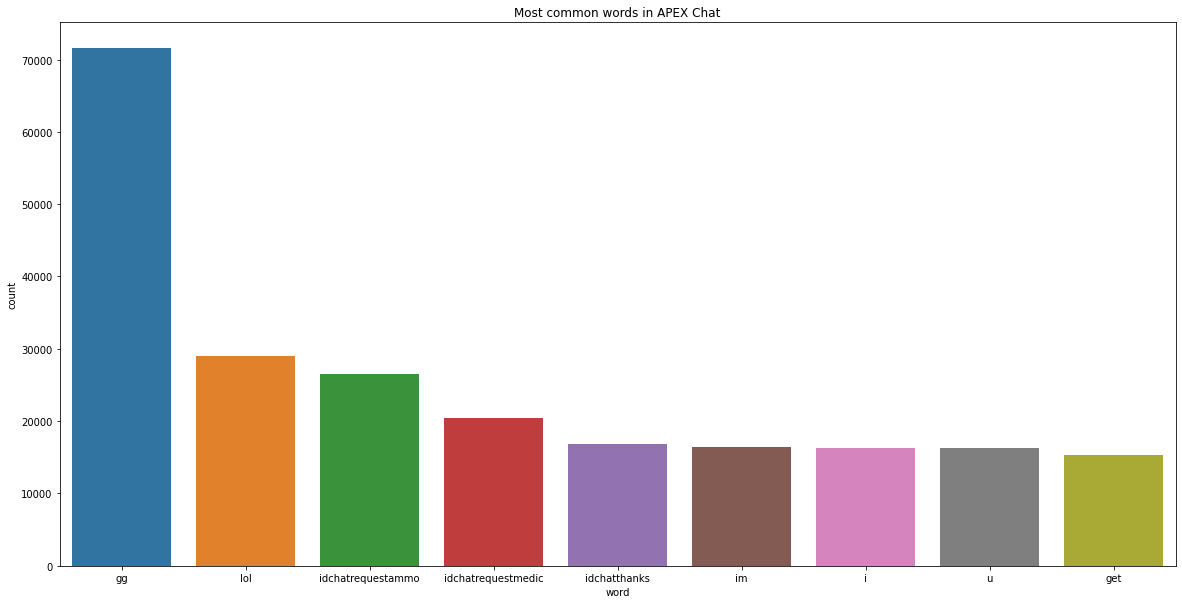

Text(0.5, 1.0, 'Most common words in APEX Chat')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

df = pd.DataFrame.from_records(finalCount[0:9], columns=["word", "count"])

plt.figure(figsize=(20,10))
sns.barplot("word", "count", data=df).set_title("Most common words in APEX Chat")

# Results
So, there are some things that seem weird here to the uninitated. Some things like `idchatrequestammo` are a quick-chat feature that get put into chat, as well as the character shouting "I need ammo!". These are special inputs that will be automatically translated to the player's specific language.
If you don't play many computer games, "GG" stands for "Good Game" and is usually said after every round by many people in the chat. This one doesn't surprise me. Same with "lol". 

# Future
In the future I'd like to add more analysis to these results, such as "what is any given player's most spoken word", and "do people swear more at different times of day?"